## Introduction
This is a sample example on how to use the data recorded from DCA1000

In [1]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install imageio pillow

In [2]:
# Import required libraries
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button, Slider
from statistics import mode


In [3]:
# Define the file name of the recorded data
'''
This file is a starting point for you on how to use radar data.
In this example (".npy" file attached to this Notebook), I recorded a 1-min data sitting on a chair facing the radar in the center, then I moved with the chair to the right side, then the left, then I returned to the center
Distance was around 1 meter
'''
# 直接读当前文件夹下的 my_recording.npy
radar_file_name = os.path.join(os.getcwd(), "my_recording.npy")
print("Using radar_file_name:", radar_file_name)


Using radar_file_name: c:\github\cx330_radar\recordings\20251105_154833\my_recording.npy


In [4]:
# Current Radar Parameters (should be the same as the one used for recording the data)
RADAR_DEVICE = "TI-IWR6843ODS"
START_FREQUENCY = 60 # GHz
FRAME_PERIOD = 62.5 # milliseconds
CHIRP_SLOPE = 45 # MHz/us
RANGE_BINS = 64
CHIRP_IDLE_TIME =   7  # us
ADC_SAMPLE_RATE =  2000   #ksps
LIGHT_SPEED = 3e8 # m/s
RAMP_END_TIME = 80 # us
NUM_CHIRPS = 64
NUM_TX_ANT = 3
NUM_RX_ANT = 4

# Calculated parameters
ADC_SAMPLE_PERIOD_USEC = 1e3 / ADC_SAMPLE_RATE * RANGE_BINS
FRAME_RATE = int(1000 / FRAME_PERIOD) # Hz
NUM_VIR_ANT = NUM_TX_ANT * NUM_RX_ANT
BANDWIDTH = CHIRP_SLOPE*ADC_SAMPLE_PERIOD_USEC*1e-3 # GHz
RANGE_RES = round(LIGHT_SPEED/(2*BANDWIDTH*1e9), 2) # m
CENTER_FREQUENCY = START_FREQUENCY * 1e9 + BANDWIDTH / 2
CHIRP_INTERVAL = (RAMP_END_TIME + CHIRP_IDLE_TIME) * 1e-6
VELOCITY_RES = LIGHT_SPEED / (2 * NUM_CHIRPS * NUM_TX_ANT * CENTER_FREQUENCY * CHIRP_INTERVAL)

print("Bandwidth: {0:.2f} GHz".format(BANDWIDTH))
print("Range Resolution: {0:.2f} m".format(RANGE_RES))
print("Velocity Resolution: {0:.2f} m/s".format(VELOCITY_RES))
print("Number of Doppler Bins: {0}".format(int(1 / VELOCITY_RES)))
print("Frame Rate: {0:.2f} Hz".format(FRAME_RATE))

# Other parameters required for processing
MAX_DISTANCE = RANGE_BINS*RANGE_RES

PHASE_ROTATION = [[1,0,0,0],
                  [0,-1,0,0],
                  [0,0,1,0],
                  [0,0,0,-1]]    # TI-IWR6843ODS
PHASE_ROTATION = np.asarray(PHASE_ROTATION)

AZIMUTH_ANT =  [0,3,4,7]
ELEVATION_ANT = [4,5,8,9]
CAPON_BINS = 20    # consider bins from 0 to 20 --> 0 to 2 meters (with range res. of 10 cm)
CAPON_FOV = 71  # scan area of -70 deg to 70 deg
CAPON_WINDOW = 2  # process CAPON_WINDOW frame at a time


Bandwidth: 1.44 GHz
Range Resolution: 0.10 m
Velocity Resolution: 0.15 m/s
Number of Doppler Bins: 6
Frame Rate: 16.00 Hz


In [5]:
# Common/useful/helper functions ---> No need to understand these functions
def clutter_remove(range_matrix):
    for range_idx in range(range_matrix.shape[1]):
        range_avg = range_matrix[:, range_idx].mean()
        range_matrix[:, range_idx] = range_matrix[:, range_idx] - range_avg
    return range_matrix

def unwrap_phase_Ambiguity(phase_queue):
    # for range_idx in range(0, points_num):
    phase_arr = phase_queue #[:, range_idx]
    phase_arr_ret = phase_arr.copy()
    phase_diff_correction_cum = 0
    for i in range(len(phase_arr)):
        if not i:
            continue
        else:
            phase_diff = phase_arr[i] - phase_arr[i - 1]
            # print(len(phase_diff))
            if phase_diff > 180:
                mod_factor = 1
            elif phase_diff < -180:
                mod_factor = -1
            else:
                mod_factor = 0
        phase_diff_mod = phase_diff - mod_factor * 2 * 180
        if phase_diff_mod == -180 and phase_diff > 0:
            phase_diff_mod = 180
        phase_diff_correction = phase_diff_mod - phase_diff
        if (phase_diff_correction < 180 and phase_diff_correction > 0) \
                or (phase_diff_correction > -180 and phase_diff_correction < 0):
            phase_diff_correction = 0
        phase_diff_correction_cum += phase_diff_correction
        phase_arr_ret[i] = phase_arr[i] + phase_diff_correction_cum
    # phase_queue[:, range_idx] = phase_arr_ret
        phase_queue = phase_arr_ret
    return phase_queue

def cov_matrix(x):
    """ 
        Calculates the spatial covariance matrix (Rxx) for a given set of input data (x=inputData). 
        Assumes rows denote Vrx axis.
    """
    
    if x.ndim > 2:
        raise ValueError("x has more than 2 dimensions.")

    if x.shape[0] > x.shape[1]:
        # warnings.warn("cov_matrix input should have Vrx as rows. Needs to be transposed", RuntimeWarning)
        x = x.T

    _, num_adc_samples = x.shape
    Rxx = x @ np.conjugate(x.T)
    Rxx = np.divide(Rxx, num_adc_samples)

    return Rxx

def gen_steering_vec(ang_est_range, ang_est_resolution, num_ant):
    """
        Generate a steering vector for AOA estimation given the theta range, theta resolution, and number of antennas
    """
    num_vec = (2 * ang_est_range / ang_est_resolution + 1)
    num_vec = int(round(num_vec))
    steering_vectors = np.zeros((num_vec, num_ant), dtype='complex64')
    for kk in range(num_vec):
        for jj in range(num_ant):
            mag = -1 * np.pi * jj * np.sin((-ang_est_range + kk * ang_est_resolution) * np.pi / 180)
            real = np.cos(mag)
            imag = np.sin(mag)

            steering_vectors[kk, jj] = complex(real, imag)

    return [num_vec, steering_vectors]

def forward_backward_avg(Rxx):
    """ 
        Performs forward backward averaging on the given input square matrix
    """
    assert np.size(Rxx, 0) == np.size(Rxx, 1)

    # --> Calculation
    M = np.size(Rxx, 0)  # Find number of antenna elements
    Rxx = np.matrix(Rxx)  # Cast np.ndarray as a np.matrix

    # Create exchange matrix
    J = np.eye(M)  # Generates an identity matrix with row/col size M
    J = np.fliplr(J)  # Flips the identity matrix left right
    J = np.matrix(J)  # Cast np.ndarray as a np.matrix

    R_fb = 0.5 * (Rxx + J * np.conjugate(Rxx) * J)

    return np.array(R_fb)

def aoa_capon(x, steering_vector, magnitude=False): #  "OpenRadar"
    """
        Perform AOA estimation using Capon (MVDR) Beamforming on a rx by chirp slice
    """

    if steering_vector.shape[1] != x.shape[0]:
        raise ValueError("'steering_vector' with shape (%d,%d) cannot matrix multiply 'input_data' with shape (%d,%d)" \
        % (steering_vector.shape[0], steering_vector.shape[1], x.shape[0], x.shape[1]))

    Rxx = cov_matrix(x)
    Rxx = forward_backward_avg(Rxx)
    Rxx_inv = np.linalg.inv(Rxx)
    
    # Calculate Covariance Matrix Rxx
    first = Rxx_inv @ steering_vector.T
    den = np.reciprocal(np.einsum('ij,ij->i', steering_vector.conj(), first.T))
    weights = np.matmul(first, den)

    if magnitude:
        return np.abs(den), weights
    else:
        return den, weights
    
#2D-CA-CFAR
# TODO: define guard and training cells parameters
def noise_cal_2d(data, x_idx, y_idx):
    result_sum = data[x_idx - 2][y_idx] + data[x_idx - 3][y_idx] + data[x_idx + 2][y_idx] + data[x_idx + 3][y_idx] + \
                 data[x_idx][y_idx - 2] + data[x_idx][y_idx + 2]

    return result_sum / 6

def ca_cfar_2d(data):
    rev_data = np.array(data)
    azimuth_fov = data.shape[0]
    elevation_fov = data.shape[1]
    decision_pairs = np.zeros((azimuth_fov, elevation_fov), dtype=float)
    points = 0

    threshold = 1.2 # TODO: need to set dynamically

    for azimuth in range(2, azimuth_fov-3, 1):
        for elevation in range(2, elevation_fov-3, 1):
            noise_ave = noise_cal_2d(rev_data, azimuth, elevation)
            if rev_data[azimuth][elevation] > (noise_ave * threshold):
                decision_pairs[azimuth][elevation] = rev_data[azimuth][elevation]
                points += 1

    return decision_pairs

def process_doppler(data, window_type='hann'):
    """
        Process Doppler data using FFT
    """
    frames, chirps = data.shape
    doppler_spectrum = np.zeros((frames, chirps), dtype=complex)
    
    # Apply window function
    if window_type == 'hann':
        window = np.hanning(chirps)
    elif window_type == 'hamming':
        window = np.hamming(chirps)
    elif window_type == 'blackman':
        window = np.blackman(chirps)
    else:
        window = np.ones(chirps)
    
    # Apply window and compute FFT for each frame
    for frame in range(frames):
        windowed_data = data[frame] * window
        doppler_spectrum[frame] = np.fft.fft(windowed_data)
    
    return doppler_spectrum


## Processing Start here

In [6]:
# Load recorded NPY file
radar_cube = np.load(radar_file_name)
print(f"Radar data shape [frames, chirps, antenna, range_bin]: {radar_cube.shape}")

Radar data shape [frames, chirps, antenna, range_bin]: (155, 64, 12, 64)


In [7]:
# Check Raw Data
print("Raw Data Shape: {0}".format(radar_cube.shape))
print("Raw Data Type: {0}".format(radar_cube.dtype))
print("Raw Data Min: {0}".format(radar_cube.min()))

Raw Data Shape: (155, 64, 12, 64)
Raw Data Type: complex64
Raw Data Min: (-7168.2353515625+346.490966796875j)


In [8]:
# Perform Clutter Removal for each antenna
decluttered_radar_cube = np.zeros(radar_cube.shape, dtype=complex)
for ant in range(NUM_VIR_ANT):
    decluttered_radar_cube[:, :, ant, :] = clutter_remove(radar_cube[:, :, ant, :])

In [9]:
# Remove DC-Offset for each antenna
for ant in range(NUM_VIR_ANT):
    decluttered_radar_cube[:, :, ant, :] = decluttered_radar_cube[:, :, ant, :] - np.mean(decluttered_radar_cube[:, :, ant, :], axis=0, keepdims=True)

## Typical Range Processing
To perform Range processing, we usually need 1 information from 1 antenna only with 1 chirp (either choose one or take the average). So we can select the data of 1 antenna and 1 chirp only.

In [10]:
# Select data of ant 0 with chirp 0:
range_data = decluttered_radar_cube[:, 0, 0, :]   # select data of ant 0 with chirp 0

In [11]:
# Compute Magnitude:
range_data_mag = np.abs(range_data)

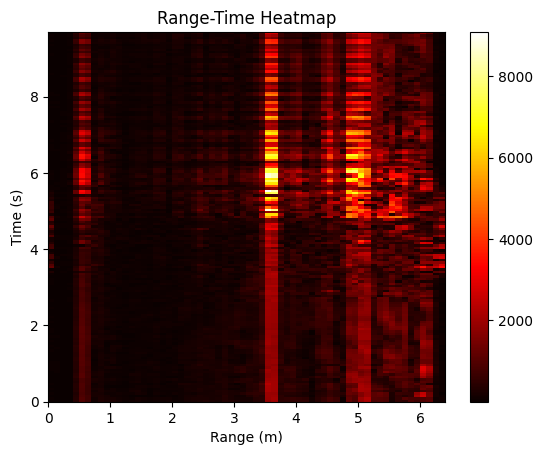

In [12]:
# Show Range-Time Heatmap
plt.imshow(range_data_mag, aspect='auto', cmap='hot', origin='lower', extent=[0, RANGE_BINS*RANGE_RES, 0, range_data_mag.shape[0]/FRAME_RATE], interpolation='nearest')
plt.xlabel('Range (m)')
plt.ylabel('Time (s)')
plt.title('Range-Time Heatmap')
plt.colorbar()
plt.show()


In [13]:
# Detect Target Range (basic method)
bins = []
for i in range(1, range_data_mag.shape[0]):
    bins.append(np.argmax(range_data_mag[-i,:]))

target_bin = mode(bins)
target_range = target_bin * RANGE_RES

print(f"target bin: {target_bin}")
print(f"Target Range: {target_range} m")


target bin: 35
Target Range: 3.5 m


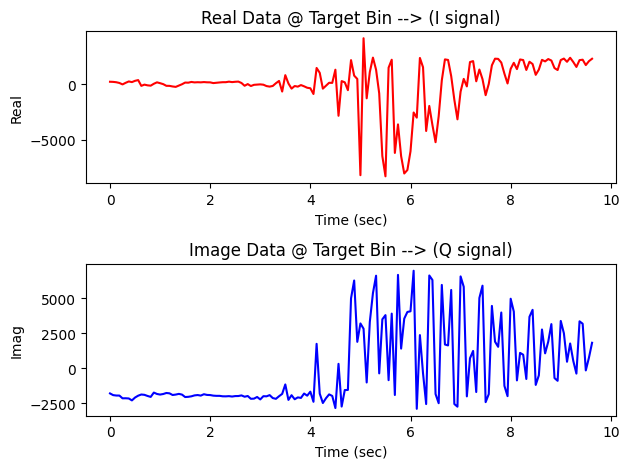

In [14]:
# Show real and Image Data of Target (IQ) --> Time-Domain representation
time_axis = np.arange(0, range_data_mag.shape[0]/FRAME_RATE, 1/FRAME_RATE)
plt.subplot(211)
plt.plot(time_axis, range_data.real[:,target_bin], 'r')
plt.xlabel('Time (sec)')
plt.ylabel('Real')
plt.title('Real Data @ Target Bin --> (I signal)')

plt.subplot(212)
plt.plot(time_axis, range_data.imag[:,target_bin], 'b')
plt.xlabel('Time (sec)')
plt.ylabel('Imag')
plt.title('Image Data @ Target Bin --> (Q signal)')

plt.tight_layout()
plt.show()

In [15]:
# Extract Phase Data of target:
target_phase = np.angle(range_data[:,target_bin], deg=True)

# Unwrap Phase
target_phase = unwrap_phase_Ambiguity(target_phase)

# Remove Phase Offset
target_phase = target_phase - target_phase[0]


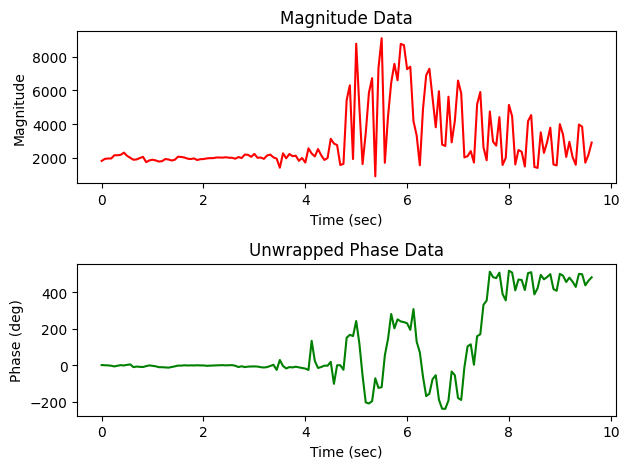

In [16]:
# Show Magnitude and Phase Data of Target --> Polar representation
time_axis = np.arange(0, range_data_mag.shape[0]/FRAME_RATE, 1/FRAME_RATE)
plt.subplot(211)
plt.plot(time_axis, range_data_mag[:,target_bin], 'r')
plt.xlabel('Time (sec)')
plt.ylabel('Magnitude')
plt.title('Magnitude Data')

plt.subplot(212)
plt.plot(time_axis, target_phase, 'g')
plt.xlabel('Time (sec)')
plt.ylabel('Phase (deg)')
plt.title('Unwrapped Phase Data')

plt.tight_layout()
plt.show()

## Doppler Processinging
To perform Doppler processing, we usually need information from 1 antenna only with **all chirps**. So we can select the data of 1 antenna only.


In [17]:
# Select data of ant 0 with all chirps for a specific range bin
doppler_data = decluttered_radar_cube[:, :, 0, target_bin]  # Using the target bin identified earlier

# Process the Doppler data
doppler_spectrum = process_doppler(doppler_data)
doppler_magnitude = np.abs(doppler_spectrum)

# Center the Doppler bins for visualization
centered_doppler = np.fft.fftshift(doppler_magnitude, axes=1)


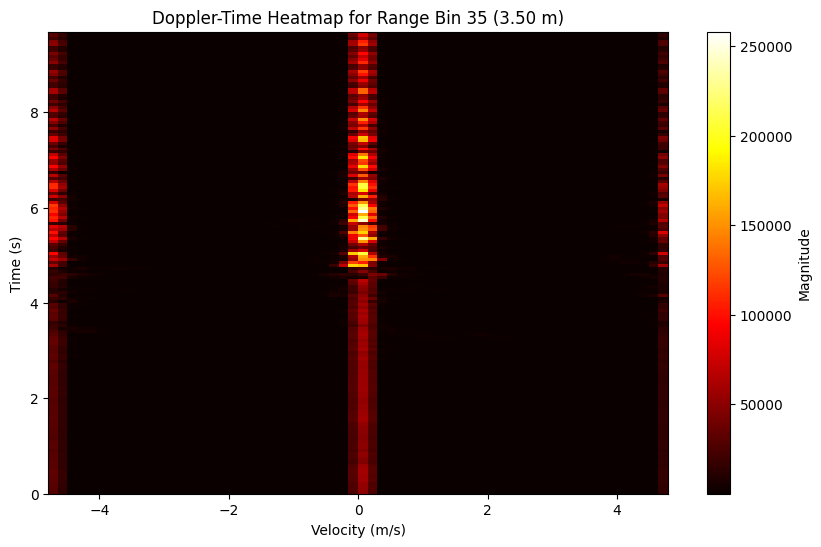

In [18]:
# Show Doppler-Time Heatmap

# Create velocity axis (centered around 0)
velocity_bins = NUM_CHIRPS
velocity_range = np.linspace(-VELOCITY_RES * velocity_bins / 2, VELOCITY_RES * velocity_bins / 2, velocity_bins)

plt.figure(figsize=(10, 6))
plt.imshow(
    centered_doppler, 
    aspect='auto', 
    cmap='hot', 
    origin='lower',
    extent=[velocity_range[0], velocity_range[-1], 0, doppler_data.shape[0]/FRAME_RATE],
    interpolation='nearest'
)
plt.colorbar(label='Magnitude')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.title(f'Doppler-Time Heatmap for Range Bin {target_bin} ({target_bin*RANGE_RES:.2f} m)')
plt.grid(False)
plt.show()

In [19]:
# Process Range-Doppler
doppler_arr = []
for frame_idx in range(decluttered_radar_cube.shape[0]):
    # Process all range bins for the selected frame
    range_doppler_map = np.zeros((RANGE_BINS, NUM_CHIRPS))
    for range_bin in range(RANGE_BINS):
        # Get data for this range bin
        range_data = decluttered_radar_cube[frame_idx, :, 0, range_bin]
        
        # Apply window and FFT
        window = np.hanning(NUM_CHIRPS)
        windowed_data = range_data * window
        doppler_spectrum = np.fft.fft(windowed_data)
        
        # Store magnitude
        range_doppler_map[range_bin, :] = np.abs(doppler_spectrum)

    # Center the Doppler bins
    centered_range_doppler = np.fft.fftshift(range_doppler_map, axes=1)
    doppler_arr.append(centered_range_doppler)

In [20]:
# Live updating Range-Doppler Heatmap
%matplotlib qt

# Set up the figure and axis once
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(bottom=0.2)  # Make room for the slider

# Initial heatmap with the first frame
heatmap = ax.imshow(
    doppler_arr[0], 
    aspect='auto', 
    cmap='hot', 
    origin='lower', 
    extent=[velocity_range[0], velocity_range[-1], 0, RANGE_BINS*RANGE_RES], 
    interpolation='nearest'
)

# Add colorbar
cbar = fig.colorbar(heatmap)

# Set labels and title
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Range (m)')
title = ax.set_title('Range-Doppler Heatmap for Frame 0')

# Add a slider for manual control (optional)
ax_slider = plt.axes([0.3, 0.05, 0.55, 0.03])
slider = Slider(
    ax=ax_slider,
    label='frame',
    valmin=1,
    valmax=len(doppler_arr),
    valinit=1,
    valstep=1
)

# Function to update the plot when the slider is moved
def update_slider(val):
    frame_idx = int(slider.val)
    heatmap.set_array(doppler_arr[frame_idx])
    title.set_text(f'Range-Doppler Heatmap for frame {frame_idx}')
    fig.canvas.draw_idle()

slider.on_changed(update_slider)

# Animation function for automatic playback
def update_animation(frame_idx):
    heatmap.set_array(doppler_arr[frame_idx])
    title.set_text(f'Range-Azimuth Heatmap for frame {frame_idx}')
    slider.set_val(frame_idx)  # Update slider position to match
    return heatmap,

# Create animation
ani = FuncAnimation(
    fig, 
    update_animation, 
    frames=len(doppler_arr), 
    interval=500,  # milliseconds between display frames
    blit=True,
    repeat=True
)

# Add play/pause button (optional)
ax_play = plt.axes([0.05, 0.05, 0.1, 0.03])
button_play = Button(ax_play, 'Play/Pause')

# Animation state
is_playing = True

def toggle_play(event):
    global is_playing
    if is_playing:
        ani.event_source.stop()
    else:
        ani.event_source.start()
    is_playing = not is_playing

button_play.on_clicked(toggle_play)

0

In [21]:
# TODO: STFT 

In [22]:
# TODO: Micro-Doppler Processing

## Angle Processing
To perform Angle processing, we usually need information from **all antennas** 

In [23]:
# Select data of all antennas with chirp 0:
angle_data = decluttered_radar_cube[:,0,:,:]   # select data of all antennas with chirp 0

In [24]:
# Initialize variables
windows = angle_data.shape[0] // FRAME_RATE
range_az_data = []
visual_matrix_e = []

# Perform Capon and CFAR algorithm for each window
for win in range(windows):
    scan_aoa_capon_a = np.zeros((CAPON_BINS, CAPON_FOV), dtype=float)
    scan_aoa_capon_e = np.zeros((CAPON_BINS, CAPON_FOV), dtype=float)

    capon_in = angle_data[win*FRAME_RATE:(win+CAPON_WINDOW)*FRAME_RATE,:,:]

    # Generate Steering Vector
    _, steering_vector_a = gen_steering_vec(CAPON_FOV-1, 2, 4)
   
    steering_vector_e = steering_vector_a.dot(PHASE_ROTATION)   # Account for antenna phase rotation (ODS)

    # Apply Capon Algorithm:
    for i in range(CAPON_BINS):
        scan_aoa_capon_a[i, :], _ = aoa_capon(capon_in[:, AZIMUTH_ANT, i].T, steering_vector_a, magnitude=True)
        scan_aoa_capon_e[i, :], _ = aoa_capon(capon_in[:, ELEVATION_ANT, i].T, steering_vector_e, magnitude=True)

    scan_aoa_capon_a = np.transpose(scan_aoa_capon_a, axes=(1,0))
    scan_aoa_capon_e = np.transpose(scan_aoa_capon_e, axes=(1,0))

    # Apply CFAR:
    scan_aoa_capon_a = ca_cfar_2d(scan_aoa_capon_a)
    scan_aoa_capon_e = ca_cfar_2d(scan_aoa_capon_e)

    # Target coordinates (Indexes in matrix)
    targetpoint_a = np.unravel_index(np.argmax(scan_aoa_capon_a), scan_aoa_capon_a.shape)
    targetpoint_e = np.unravel_index(np.argmax(scan_aoa_capon_e), scan_aoa_capon_e.shape)

    range_az_data.append(scan_aoa_capon_a)
    visual_matrix_e.append(scan_aoa_capon_e)

In [25]:
# Live updating Range-Azimuth Heatmap
%matplotlib qt

# Set up the figure and axis once
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(bottom=0.2)  # Make room for the slider

# Initial heatmap with the first frame
heatmap = ax.imshow(
    range_az_data[0].T, 
    aspect='auto', 
    cmap='hot', 
    origin='lower', 
    extent=[-CAPON_FOV, CAPON_FOV, 0, CAPON_BINS*RANGE_RES], 
    interpolation='nearest'
)

# Add colorbar
cbar = fig.colorbar(heatmap)

# Set labels and title
ax.set_xlabel('Azimuth (deg)')
ax.set_ylabel('Range (m)')
title = ax.set_title('Range-Azimuth Heatmap for sec 1')

# Add a slider for manual control (optional)
ax_slider = plt.axes([0.3, 0.05, 0.55, 0.03])
slider = Slider(
    ax=ax_slider,
    label='Time (sec)',
    valmin=1,
    valmax=len(range_az_data),
    valinit=1,
    valstep=1
)

# Function to update the plot when the slider is moved
def update_slider(val):
    frame_idx = int(slider.val)
    heatmap.set_array(range_az_data[frame_idx].T)
    title.set_text(f'Range-Azimuth Heatmap for sec {frame_idx}')
    fig.canvas.draw_idle()

slider.on_changed(update_slider)

# Animation function for automatic playback
def update_animation(frame_idx):
    heatmap.set_array(range_az_data[frame_idx].T)
    title.set_text(f'Range-Azimuth Heatmap for sec {frame_idx}')
    slider.set_val(frame_idx)  # Update slider position to match
    return heatmap,

# Create animation
ani = FuncAnimation(
    fig, 
    update_animation, 
    frames=len(range_az_data), 
    interval=1000,  # milliseconds between display frames
    blit=True,
    repeat=True
)

# Add play/pause button (optional)
ax_play = plt.axes([0.05, 0.05, 0.1, 0.03])
button_play = Button(ax_play, 'Play/Pause')

# Animation state
is_playing = True

def toggle_play(event):
    global is_playing
    if is_playing:
        ani.event_source.stop()
    else:
        ani.event_source.start()
    is_playing = not is_playing

button_play.on_clicked(toggle_play)

0

## Point-Cloud Generation
To generate point-cloud, we need to combine the results of Range, Doppler, and Angle processing.
"""

In [26]:
# ===================== Simple 3D Point Cloud =====================
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (为了启用 3D)

# 选一个要可视化的时间窗口（跟前面的 range_az_data / visual_matrix_e 对应）
# 0 表示第 1 秒，1 表示第 2 秒……
win_idx = 0
print(f"Using window index: {win_idx}, total windows: {len(range_az_data)}")

az_map = range_az_data[win_idx]      # 形状: [angle_bin, range_bin]
el_map = visual_matrix_e[win_idx]    # 形状: [angle_bin, range_bin]

angle_bins, range_bins = az_map.shape

# 角度轴（跟 gen_steering_vec(CAPON_FOV-1, 2, 4) 保持一致）
ang_res = 2.0
ang_range = CAPON_FOV - 1           # 实际从 -70 到 +70（如果 CAPON_FOV = 71）
angles_deg = np.linspace(-ang_range, ang_range, angle_bins)

# 距离轴
ranges_m = np.arange(range_bins) * RANGE_RES

# 阈值：把太弱的点滤掉（可以自己调）
amp_thresh = az_map.max() * 0.3
print("Amplitude threshold:", amp_thresh)

xs, ys, zs, intens = [], [], [], []

for a_idx in range(angle_bins):
    for r_idx in range(range_bins):
        amp_az = az_map[a_idx, r_idx]
        if amp_az <= amp_thresh:
            continue  # 弱的点不要

        # 水平方向方位角（azimuth）
        az_deg = angles_deg[a_idx]
        r = ranges_m[r_idx]

        # 垂直方向俯仰角（elevation）——用同一距离单元上 elevation 图里最强的一根
        el_col = el_map[:, r_idx]
        if np.any(el_col > 0):
            e_idx = np.argmax(el_col)
            el_deg = angles_deg[e_idx]
        else:
            el_deg = 0.0   # 如果没有明显能量，就假设在 0° 平面上

        az = np.deg2rad(az_deg)
        el = np.deg2rad(el_deg)

        # 球坐标 → 笛卡尔坐标
        # 约定：x = 前后（朝雷达正前方），y = 左右，z = 上下
        x = r * np.cos(el) * np.cos(az)
        y = r * np.cos(el) * np.sin(az)
        z = r * np.sin(el)

        xs.append(x)
        ys.append(y)
        zs.append(z)
        intens.append(amp_az)

xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)
intens = np.array(intens)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(xs, ys, zs, c=intens, cmap='hot', s=20)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title(f"3D Point Cloud (window {win_idx + 1})")
fig.colorbar(p, ax=ax, label="Intensity")

# 让坐标轴比例更接近 1:1:1，看着不变形
max_range = max(np.max(np.abs(xs)), np.max(np.abs(ys)), np.max(np.abs(zs)) + 1e-6)
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(0, max_range)

plt.show()

Using window index: 0, total windows: 9
Amplitude threshold: 19474.305161767068


In [ ]:
# ====== 把 RD / RA / PointCloud 全部导出为 gif + 每一帧 png ======
import os
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (只是为了触发 3D)

# 以 my_recording.npy 所在目录作为本次 session 目录
session_dir = os.path.dirname(radar_file_name)

# 总输出目录：recordings\2025xxxx_xxxxxx\offline_plots
export_root = os.path.join(session_dir, "offline_plots")
os.makedirs(export_root, exist_ok=True)

# 各自的帧目录
rd_frames_dir = os.path.join(export_root, "range_doppler_frames")
ra_frames_dir = os.path.join(export_root, "range_azimuth_frames")
pc_frames_dir = os.path.join(export_root, "point_cloud_frames")
for d in (rd_frames_dir, ra_frames_dir, pc_frames_dir):
    os.makedirs(d, exist_ok=True)


# ---------- 小工具：把一组 2D 矩阵存成 png + gif ----------
def save_heatmap_sequence(arr_list, extent, frames_dir,
                          gif_path, xlabel, ylabel, title_prefix):
    png_paths = []
    for i, mat in enumerate(arr_list):
        fig, ax = plt.subplots(figsize=(6, 4))
        im = ax.imshow(
            mat,
            aspect="auto",
            cmap="hot",
            origin="lower",
            extent=extent,
            interpolation="nearest"
        )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title_prefix} {i}")
        fig.colorbar(im)

        png_file = os.path.join(frames_dir, f"frame_{i:04d}.png")
        # 注意：不要再用 bbox_inches="tight"，否则每一帧大小可能不同
        fig.savefig(png_file, dpi=120)
        plt.close(fig)
        png_paths.append(png_file)

    # 合成 gif
    if png_paths:
        imgs = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(gif_path, imgs, duration=0.2)  # 每帧 0.2s
        print("saved gif:", gif_path)
    else:
        print("no frames for", gif_path)


# ---------- 1) Range–Doppler：gif + 每帧 ----------
# 这里用前面算好的 doppler_arr 和 velocity_range
rd_extent = [velocity_range[0], velocity_range[-1],
             0, RANGE_BINS * RANGE_RES]

save_heatmap_sequence(
    arr_list=doppler_arr,                    # 形状: [n_frames, range_bin, doppler_bin]
    extent=rd_extent,
    frames_dir=rd_frames_dir,
    gif_path=os.path.join(export_root, "range_doppler.gif"),
    xlabel="Velocity (m/s)",
    ylabel="Range (m)",
    title_prefix="Range-Doppler frame"
)


# ---------- 2) Range–Azimuth：gif + 每帧 ----------
# range_az_data 里每个元素大概是 [azimuth_bin, range_bin]，画图时用 .T
ra_extent = [-CAPON_FOV, CAPON_FOV,
             0, CAPON_BINS * RANGE_RES]

save_heatmap_sequence(
    arr_list=[ra.T for ra in range_az_data],
    extent=ra_extent,
    frames_dir=ra_frames_dir,
    gif_path=os.path.join(export_root, "range_azimuth.gif"),
    xlabel="Azimuth (deg)",
    ylabel="Range (m)",
    title_prefix="Range-Azimuth sec"
)

# ---------- 3) 3D Point Cloud：gif + 每帧 ----------
# 这里利用 range_az_data 和 visual_matrix_e，大致做一个点云投影
pc_png_paths = []

# 注意：range_az_data[0] 形状是 (az_bins, range_bins)
az_bins, range_bins = range_az_data[0].shape        # (CAPON_FOV, CAPON_BINS)
el_bins, _         = visual_matrix_e[0].shape       # (CAPON_FOV, CAPON_BINS)

# 角度轴（和画 RA 图一样，从 -CAPON_FOV 到 CAPON_FOV）
az_grid = np.linspace(-CAPON_FOV, CAPON_FOV, az_bins)   # 方位角
el_grid = np.linspace(-CAPON_FOV, CAPON_FOV, el_bins)   # 俯仰角

for win_idx, (ra_map, el_map) in enumerate(zip(range_az_data, visual_matrix_e)):
    # ra_map: [az, range]，先转成 [range, az]，跟 range 用同一维
    ra_map = ra_map.T          # (range_bins, az_bins)
    el_map = el_map.T          # (range_bins, el_bins)

    # 简单阈值：取当前窗口强度最高的 2% 点
    thr = np.percentile(ra_map, 98)
    mask = ra_map > thr
    if not mask.any():
        continue

    r_idx, a_idx = np.where(mask)
    r = (r_idx + 0.5) * RANGE_RES       # m
    az_deg = az_grid[a_idx]

    # elevation 从 el_map 里取同一 azimuth 列的最大值所在行作为代表
    e_col = el_map[:, a_idx]           # 形状：(range_bins, Npoints)
    e_idx = np.argmax(e_col, axis=0)
    el_deg = el_grid[e_idx]

    az_rad = np.deg2rad(az_deg)
    el_rad = np.deg2rad(el_deg)

    # 简单雷达坐标系：Z 向上，X/Y 为水平平面
    x = r * np.cos(el_rad) * np.sin(az_rad)
    y = r * np.cos(el_rad) * np.cos(az_rad)
    z = r * np.sin(el_rad)

    intensity = ra_map[mask]

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(x, y, z, c=intensity, s=15, cmap="hot")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"3D Point Cloud (window {win_idx})")
    ax.set_xlim(-MAX_DISTANCE, MAX_DISTANCE)
    ax.set_ylim(-MAX_DISTANCE, MAX_DISTANCE)
    ax.set_zlim(0, MAX_DISTANCE / 2)
    fig.colorbar(sc, label="Intensity")

    pc_file = os.path.join(pc_frames_dir, f"pc_{win_idx:04d}.png")
    fig.savefig(pc_file, dpi=120)   # 不要 bbox_inches="tight"
    plt.close(fig)
    pc_png_paths.append(pc_file)

# 合成点云 gif（这一段保持不变）
if pc_png_paths:
    imgs = [imageio.imread(p) for p in pc_png_paths]
    gif_pc_path = os.path.join(export_root, "point_cloud.gif")
    imageio.mimsave(gif_pc_path, imgs, duration=0.5)
    print("saved gif:", gif_pc_path)
else:
    print("point cloud: no strong points, skip gif")


for win_idx, (ra_map, el_map) in enumerate(zip(range_az_data, visual_matrix_e)):
    # ra_map: [az, range]，先转成 [range, az]，跟 range 用同一维
    ra_map = ra_map.T
    el_map = el_map.T

    # 简单阈值：取当前窗口强度最高的 2% 点
    thr = np.percentile(ra_map, 98)
    mask = ra_map > thr
    if not mask.any():
        continue

    r_idx, a_idx = np.where(mask)
    r = (r_idx + 0.5) * RANGE_RES       # m
    az_deg = az_grid[a_idx]

    # elevation 从 el_map 里取同一 azimuth 列的最大值所在行作为代表
    e_col = el_map[:, a_idx]
    e_idx = np.argmax(e_col, axis=0)
    el_deg = el_grid[e_idx]

    az_rad = np.deg2rad(az_deg)
    el_rad = np.deg2rad(el_deg)

    # 简单雷达坐标系：Z 向上，X/Y 为水平平面
    x = r * np.cos(el_rad) * np.sin(az_rad)
    y = r * np.cos(el_rad) * np.cos(az_rad)
    z = r * np.sin(el_rad)

    intensity = ra_map[mask]

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(x, y, z, c=intensity, s=15, cmap="hot")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"3D Point Cloud (window {win_idx})")
    ax.set_xlim(-MAX_DISTANCE, MAX_DISTANCE)
    ax.set_ylim(-MAX_DISTANCE, MAX_DISTANCE)
    ax.set_zlim(0, MAX_DISTANCE / 2)
    fig.colorbar(sc, label="Intensity")

    pc_file = os.path.join(pc_frames_dir, f"pc_{win_idx:04d}.png")
    # 同样这里也不要 bbox_inches="tight"
    fig.savefig(pc_file, dpi=120)
    plt.close(fig)
    pc_png_paths.append(pc_file)

# 合成点云 gif
if pc_png_paths:
    imgs = [imageio.imread(p) for p in pc_png_paths]
    gif_pc_path = os.path.join(export_root, "point_cloud.gif")
    imageio.mimsave(gif_pc_path, imgs, duration=0.5)
    print("saved gif:", gif_pc_path)
else:
    print("point cloud: no strong points, skip gif")


saved gif: c:\github\cx330_radar\recordings\20251105_154833\offline_plots\range_doppler.gif
saved gif: c:\github\cx330_radar\recordings\20251105_154833\offline_plots\range_azimuth.gif


IndexError: index 49 is out of bounds for axis 0 with size 20

In [ ]:
# TODO: Show Point Cloud

In [ ]:
# TODO: Segmentation and g-tracking